text embedding started
['「국민건강보험법」제41조제3항 및 제4항, 「국민건강보험법 시행령」 ', '제19조제1항 관련 별표2 및 「국민건강보험 요양급여의 기준에 관한 ', '규칙」제5조제2항에 의한 「요양급여의 적용기준 및 방법에 관한 세부 ', '사항(보건복지부 고시 제2024-176호, 2024.8.29.)」을 다음과 같이 개정ㆍ발 ', '2024년 9월 12일 ', '보건복지부 장관 ', '「요양급여의 적용기준 및 방법에 관한 세부사항」일부개정 ', '요양급여의 적용기준 및 방법에 관한 세부사항 일부를 다음과 같이 ', 'Ⅰ. 행위 제19장 응급의료수가 중 일반사항의 응급실 재방문시 수가 ', '산정 기준란을 다음과 같이 한다. ', '일반사항 응급실 ', '응급실 내원환자가 동일상병 또는 증상으로 당일 ', '또는 퇴실후 6시간 이내 응급실을 재방문하는 경우 ', '수가산정 기준  응급실 진료가 계속된 것과 동일하게 응급의료수가를 ', '1. 응1 응급의료관리료, 응3 중증응급환자 진료구역 ', '관찰료, 응4 응급환자 진료구역 관찰료, 응7 응급 ', '환자 중증도 분류 및 선별료, 응7-1 정신응급환자 ', '초기 평가료, 응8 외상환자 관리료 등은 1회에 ', '2. 응급실 방문 중 한 번이라도 입원환자 본인부담률 ', '산정조건에 해당되면, 전체 응급실 요양급여비용은 ', '입원환자 본인부담률에 따라 산정함. ', '', '3. 위의 2.에 해당하지 않은 경우로 「국민건강보험법 \n시행규칙」 [별표 6] 제1호사목 2)‧3)에 따라 \n본인부담률을 달리 적용할 경우 각각의 본인부담률로 \n산정함. ', 'Ⅰ. 행위 제19장 응급의료수가 중 응3 중증응급환자 진료구역 관찰료 산정 ', '방법의 중증응급환자 진료구역 관찰료 산정기준란을 다음과 같이 한다. ', '중증응급환자  1. ‘중증응급환자 진료구역’은「응급의료에 관한 법률」 ', '중증응급환자  진료구역 ', '시행규칙에서 정한 시설을 의미하며, 권역응급 ', '의료센터 

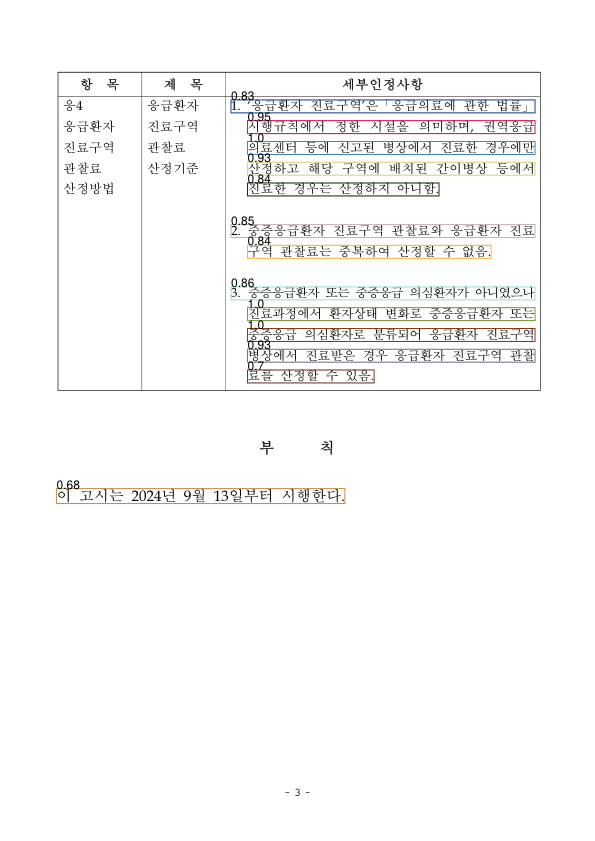

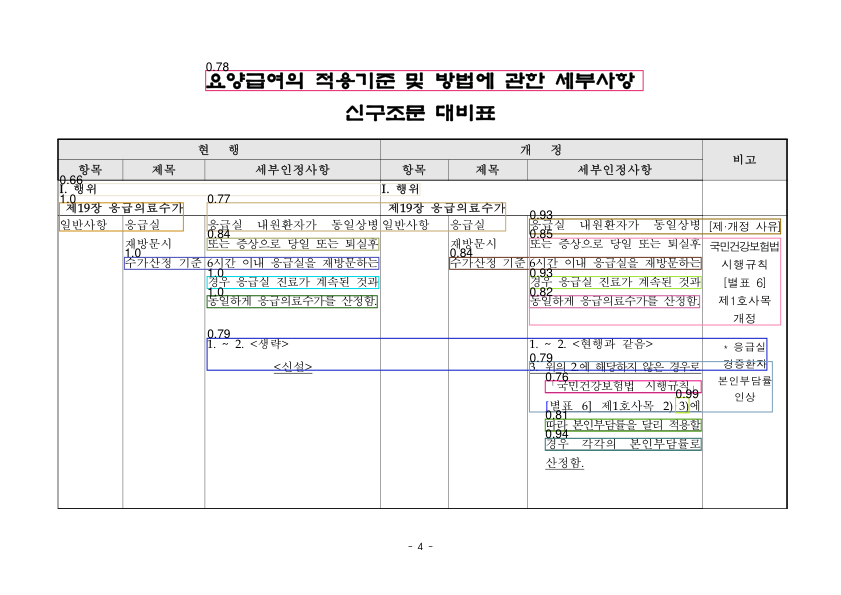

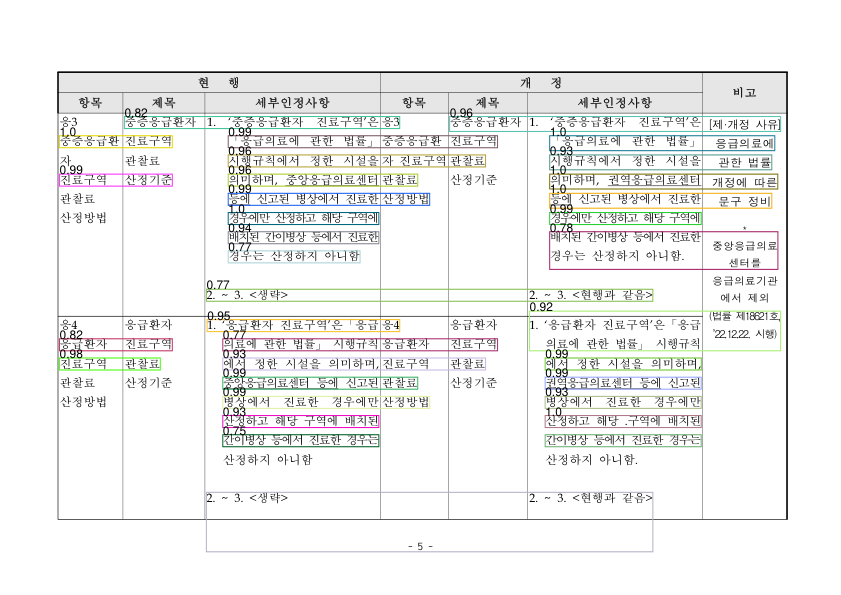

No images to display


In [ ]:

from __future__ import annotations

from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel
import openparse

file_path = r'C:\work\yangji\src\insurance-demo\src\data'
file_path = r"C:\work\yangji\src\insurance-demo\src\data\★(제2024-181호, 9.12.) 요양급여의 적용기준 및 방법에 관한 세부사항 일부개정안_v3.pdf"

import openparse
from openparse import processing, Pdf


class MinimalIngestionPipeline(processing.IngestionPipeline):
    def __init__(self):
        self.transformations = [
            # combines bullets and weird formatting
            processing.CombineNodesSpatially(
                x_error_margin=10,
                y_error_margin=2,
                criteria="both_small",
            ),
            processing.CombineHeadingsWithClosestText(),
            processing.CombineBullets(),
            processing.RemoveMetadataElements(),
            processing.RemoveNodesBelowNTokens(min_tokens=10),
        ]

parser = openparse.DocumentParser(
    processing_pipeline=MinimalIngestionPipeline(),
)
# parsed_basic_doc = parser.parse(file_path)
parsed_content = parser.parse(file_path)

# for i in parsed_basic_doc.nodes:
#     print(i)

from openparse import Node
from openparse import processing
import numpy as np
from IPython.display import display, Image

MODEL_NAME = "text-multilingual-embedding-002"
DIMENSIONALITY = 768


def embed_text(
    texts: list[str] = ["Retrieve a function that adds two numbers"],
    task: str = "FACT_VERIFICATION",
    model_name: str = "text-embedding-005",
    dimensionality: int | None = 768,
) -> list[list[float]]:
    """Embeds texts with a pre-trained, foundational model."""
    model = TextEmbeddingModel.from_pretrained(model_name)
    inputs = [TextEmbeddingInput(text, task) for text in texts]
    kwargs = dict(output_dimensionality=dimensionality) if dimensionality else {}
    embeddings = model.get_embeddings(inputs, **kwargs)
    # Example response:
    # [[0.025890009477734566, -0.05553026497364044, 0.006374752148985863,...],
    return [embedding.values for embedding in embeddings]

def cosine_similarity(
    a: np.ndarray | list[float], b: np.ndarray | list[float]
) -> float:
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def dot_product_similarity(
    a: np.ndarray | list[float], b: np.ndarray | list[float]
) -> float:
    return np.dot(a, b)

def get_node_similarities(nodes: list[Node]):
    # Filter out nodes with empty text
    non_empty_nodes = [node for node in nodes if node.text.strip()]
    
    # Get the similarity of each node with the node that precedes it
    embeddings = embed_text([node.text for node in non_empty_nodes], task="FACT_VERIFICATION")
    similarities = []
    for i in range(1, len(embeddings)):
        similarities.append(cosine_similarity(embeddings[i - 1], embeddings[i]))

    similarities = [round(sim, 2) for sim in similarities]
    return [0] + similarities


doc = Pdf(file=file_path)

# print("parsed_content.nodes", parsed_content.nodes)
print("text embedding started")
print([node.text for node in parsed_content.nodes])
annotations = get_node_similarities(parsed_content.nodes)
# Ensure the number of annotations matches the number of nodes
if len(annotations) < len(parsed_content.nodes):
    annotations.extend([0] * (len(parsed_content.nodes) - len(annotations)))
elif len(annotations) > len(parsed_content.nodes):
    annotations = annotations[:len(parsed_content.nodes)]

images = doc.display_with_bboxes(
    parsed_content.nodes, annotations=annotations, page_nums=[2, 3, 4]
)

# Display images in a separate window
if images:
    for img in images:
        display(Image(img))
else:
    print("No images to display")